# Análisis de clientes del banco Beta Bank

## Preprocesamiento de datos

###  Importar las librerias que se usaran

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn. linear_model import LogisticRegression

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.utils import shuffle

### analizar la información de los datos

In [2]:
#subir el archivo
data=pd.read_csv('/datasets/Churn.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
mean=data['Tenure'].mean()
data['Tenure']=data['Tenure'].fillna(mean)

In [6]:
#verificar que no hayan duplicados explicitos
print ('Cantidad de filas duplicadas',data.duplicated().sum())

#verificar que no hayan duplicados implicitos
print('Cantidad de usuarios duplicado',data['CustomerId'].duplicated().sum())

Cantidad de filas duplicadas 0
Cantidad de usuarios duplicado 0


De los datos se observa que el tipo de cada uno es correcto, todas las columnas excepto por una no tienen datos nulos excepto por tenure, que es los años en los que el cliente a madurado el deposito a plazo fijo, se puso el valor de la media. También se observa que no hay filas duplicadas, ni usuarios que esten duplicados.

## Examinar el equilibrio de las clases (Investigación de modelos)

Para el análisis las columnas RowNumber, CustomerId, Surname no me apartan valor para esta parte, por lo que las elimino. Debido a que estas columnas no nos dan ninguna característica, solo es para indicar que es un usuario. y son diferentes para cada uno

In [7]:
new_data=data.drop(['RowNumber', 'CustomerId', 'Surname'], axis='columns')

### Algortimo árbole de decisión

Geography y Gender son características categóricas se debe convertir en numéricas, para el modelo de arboles se hace con codificación de etiquetas

In [8]:
encoder= OrdinalEncoder()
encoder.fit(new_data)
data_ordinal=pd.DataFrame(encoder.transform(new_data), columns=new_data.columns)

data_ordinal

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0,1.0
1,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0,0.0
2,111.0,0.0,0.0,24.0,9.0,5793.0,2.0,1.0,0.0,5707.0,1.0
3,308.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4704.0,0.0
4,459.0,2.0,0.0,25.0,2.0,3696.0,0.0,1.0,1.0,3925.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9995,380.0,0.0,1.0,21.0,6.0,0.0,1.0,1.0,0.0,4827.0,0.0
9996,125.0,0.0,1.0,17.0,11.0,124.0,0.0,1.0,1.0,5087.0,0.0
9997,318.0,0.0,0.0,18.0,8.0,0.0,0.0,0.0,1.0,2062.0,1.0
9998,381.0,1.0,1.0,24.0,3.0,427.0,1.0,1.0,0.0,4639.0,1.0


#### Segmentar los datos en conjunto de entrenamiento, validación y prueba

Se divide el conjunto de datos en:

60% de entrenamiento

20% validación

20% prueba

In [9]:
df_train, df_valid_test = train_test_split(data_ordinal, test_size=0.4, random_state=12345)
df_valid,df_test=train_test_split(df_valid_test, test_size=0.5, random_state=12345)

In [10]:
#Se separa cada conjunto de datos en caracteristicas y el objetivo
features_train_ordinal= df_train.drop('Exited',axis=1)
target_train_ordinal=df_train['Exited']

features_valid_ordinal=df_valid.drop('Exited',axis=1)
target_valid_ordinal=df_valid['Exited']

features_test_ordinal=df_test.drop('Exited',axis=1)
target_test_ordinal=df_test['Exited']

In [11]:
best_accuracy=0
best_depth=0
for depth in range(1,11):
    tree_model=DecisionTreeClassifier(max_depth=depth, random_state=12345)
    tree_model.fit(features_train_ordinal,target_train_ordinal)
    predictions=tree_model.predict(features_valid_ordinal)
    accuracy=accuracy_score(target_valid_ordinal,predictions)
    if accuracy>best_accuracy:
        best_accuracy=accuracy
        best_depth=depth
        
        target_predict=predictions
print(classification_report(target_valid_ordinal, target_predict))
print (f'La mejor exactitud fue de {best_accuracy}, se obtuvo para un model con max_depth= {best_depth} ')

              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91      1582
         1.0       0.75      0.44      0.55       418

    accuracy                           0.85      2000
   macro avg       0.81      0.70      0.73      2000
weighted avg       0.84      0.85      0.84      2000

La mejor exactitud fue de 0.852, se obtuvo para un model con max_depth= 4 


### Algoritmo de bosque aleatorio
Se hara un bucle para encontrar cual es el valor n_estimate y max_depth en donde se obtiene mejor resultado

In [12]:
#Bosque aleatorio
best_score = 0
best_est = 0
best_depth=0
for est in range(1,40):
    for depth in range(1,11):
        forest_model = RandomForestClassifier(random_state=54321, n_estimators=est, max_depth=depth) 
        forest_model.fit(features_train_ordinal,target_train_ordinal) 
        score = forest_model.score(features_valid_ordinal,target_valid_ordinal)

        if score > best_score:
            best_score =score 
            best_est = est
            best_depth=depth
            target_predict=forest_model.predict(features_valid_ordinal)
            
print(classification_report(target_valid_ordinal, target_predict))

print(f'La mejor exactitud fue de {best_score}, se obtuvo para un model con n_estimators= {best_est} y max_depth= {best_depth}')

              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92      1582
         1.0       0.79      0.46      0.58       418

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000

La mejor exactitud fue de 0.861, se obtuvo para un model con n_estimators= 7 y max_depth= 10


In [13]:
# Se realiza una matriz de confusión 
print(confusion_matrix(target_valid_ordinal, target_predict))

[[1531   51]
 [ 227  191]]


El modelo ve a menudo ve respuestas negativas donde no lo son.

### Regresión logística
Para este caso hacemos la codificación one-hot, esto debido a que cuando se hace regresión logística se deben codificar las variables categóricas en variables independientes, que es lo que hace esta codificación. Lo que hace one-hot encoding es crear nuevas columnas con cada categoría y poner 1 en la categoría que es cada cosa. Para evitar caer en la trampa dummy se eliminan columnas donde los valores se pueden deducir de las otras columnas.

In [14]:
data_ohe=pd.get_dummies(new_data, drop_first=True)

In [15]:
#Se divide los datos
df_train_ohe, valid_test_ohe = train_test_split(data_ohe, test_size=0.4, random_state=12345)
df_valid_ohe,df_test_ohe=train_test_split(valid_test_ohe, test_size=0.5, random_state=12345)

In [16]:
#Se separa cada conjunto de datos en caracteristicas y el objetivo
features_train_ohe= df_train_ohe.drop('Exited',axis=1)
target_train_ohe=df_train_ohe['Exited']

features_valid_ohe=df_valid_ohe.drop('Exited',axis=1)
target_valid_ohe=df_valid_ohe['Exited']

features_test_ohe=df_test_ohe.drop('Exited',axis=1)
target_test_ohe=df_test_ohe['Exited']

In [17]:
regression_model=LogisticRegression(random_state=12345, solver='liblinear')
regression_model.fit(features_train_ohe,target_train_ohe)
score_valid=regression_model.score(features_valid_ohe,target_valid_ohe)
print(f' La exactitud para el modelo de regresión logistica es {score_valid}')

 La exactitud para el modelo de regresión logistica es 0.7815


In [18]:
target_predict_ohe=regression_model.predict(features_valid_ohe)
print(classification_report(target_valid_ohe, target_predict_ohe))

              precision    recall  f1-score   support

           0       0.79      0.98      0.88      1582
           1       0.34      0.05      0.08       418

    accuracy                           0.78      2000
   macro avg       0.57      0.51      0.48      2000
weighted avg       0.70      0.78      0.71      2000



In [19]:
# Se realiza una matriz de confusión 
print(confusion_matrix(target_valid_ohe, target_predict_ohe))
print()
print('F1:', f1_score(target_valid_ohe, target_predict_ohe))

[[1543   39]
 [ 398   20]]

F1: 0.08385744234800838


De esto se puede ver que el modelo es bastante pesimo porque hay muchos casos, casi la mayoria en donde el modelo predice negativos no lo son.

### Conclusión

Se entreno tres tipos de modelos diferentes, un árbol de decisión, un bosque aleatorio y uno de regresión logística. El modelo que tuvo mejor resultado fue el de bosque aleatorio, sin embargo no es un buen modelo ya que hay muchos casos donde predice negativos cuando no lo son y lo mismo sucede con el modelo de regresión logística pero a mayor escala. Esto puede deberse a que hay mucho casos en donde el objetivo es negativo y por eso el modelo esta haciendo estas predicciones incorrectas. Para mejorar esto se puede un sobremuestreo o un submuestreo. También se puede mirar si algunas observaciones del conjunto son más importantes y se les asigna un peso.

## Mejorar la calidad del modelo

### Ajuste de peso 

Se usa el argumento class_weight, donde a la clase rara le asigna un peso mayor

In [20]:
model_1=LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_1.fit(features_train_ohe,target_train_ohe)
predicted_valid_1=model_1.predict(features_valid_ohe)

print('F1:', f1_score(target_valid_ohe, predicted_valid_1))
print()
print(confusion_matrix(target_valid_ohe, predicted_valid_1))

F1: 0.49166666666666664

[[1095  487]
 [ 123  295]]


#### Curva ROC

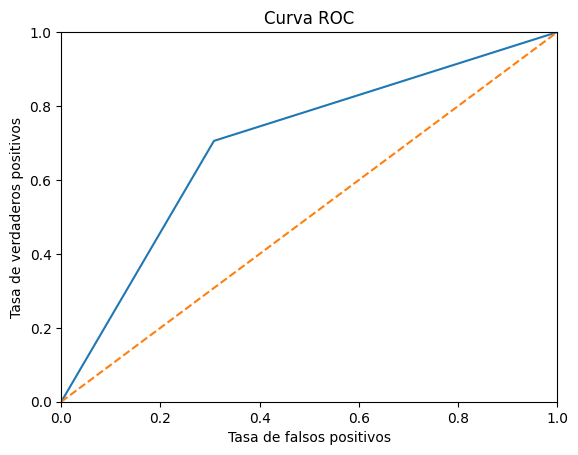

El valor de auc_roc es de: 0.7537231050272503


In [21]:
probabilities_valid = model_1.predict_proba(features_valid_ohe)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid_ohe,predicted_valid_1)

plt.figure()
plt.plot(fpr,tpr)

# Curva ROC para modelo aleatorio
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

auc_roc=roc_auc_score(target_valid_ohe,probabilities_one_valid)
print('El valor de auc_roc es de:',auc_roc)

### Sobremuestreo
Se divide el conjunto de datos de entrenamiento en observaciones positivas y negativas, luego se duplican las observaciones positivas de tal manera que las dos clases tengan tamaños similares. Se muliplica por 4 y luego se mezclan los datos.

In [22]:
#Defino una función para sobremuestreo
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(features_train_ohe, target_train_ohe, 4)

In [23]:
#Se crea el modelo 
model_2=LogisticRegression(random_state=12345,solver='liblinear')
model_2.fit(features_upsampled,target_upsampled)
predicted_valid_2=model_2.predict(features_valid_ohe)

print('F1:', f1_score(target_valid_ohe, predicted_valid_2))
print(confusion_matrix(target_valid_ohe, predicted_valid_2))

F1: 0.4512489927477841
[[1039  543]
 [ 138  280]]


#### Curva ROC 

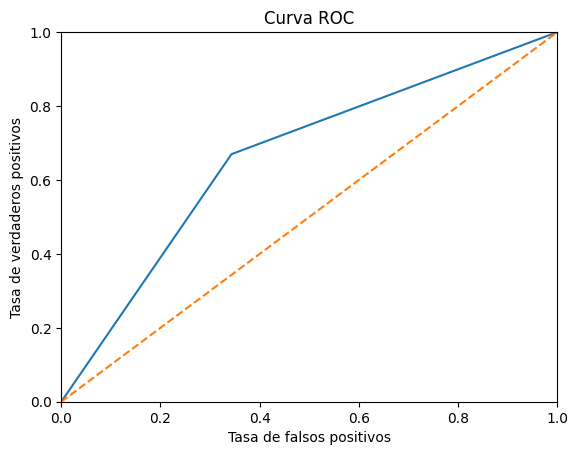

El valor de auc_roc es de: 0.7202726244412317


In [24]:
probabilities_valid = model_2.predict_proba(features_valid_ohe)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid_ohe,predicted_valid_2)

plt.figure()
plt.plot(fpr,tpr)

# Curva ROC para modelo aleatorio
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

auc_roc=roc_auc_score(target_valid_ohe,probabilities_one_valid)
print('El valor de auc_roc es de:',auc_roc)

### Submuestreo
Se divide el conjunto de datos en clases, después con la función sample() se selecciona aleatoriamente una fracción de los datos de la clase predominante para eliminar y se combinan las observaciones

In [25]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)]+ [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)]+ [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(features_train_ohe, target_train_ohe, 0.3)

In [26]:
#Se crea el modelo
model_3=LogisticRegression(random_state=12345, solver='liblinear')
model_3.fit(features_downsampled, target_downsampled)
predicted_valid_3=model_3.predict(features_valid_ohe)

print('F1:', f1_score(target_valid_ohe, predicted_valid_3))
print()
print(confusion_matrix(target_valid_ohe, predicted_valid_3))

F1: 0.4601449275362319

[[1150  432]
 [ 164  254]]


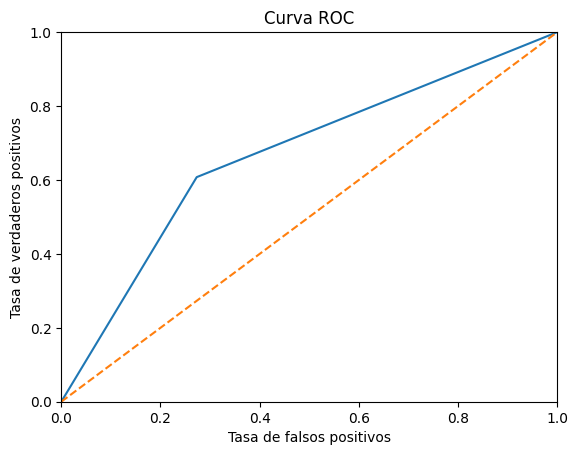

El valor de auc_roc es de: 0.7152837846829463


In [27]:
probabilities_valid = model_3.predict_proba(features_valid_ohe)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid_ohe,predicted_valid_3)

plt.figure()
plt.plot(fpr,tpr)

# Curva ROC para modelo aleatorio
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

auc_roc=roc_auc_score(target_valid_ohe,probabilities_one_valid)
print('El valor de auc_roc es de:',auc_roc)

### Conclusiones

Para mejorar el modelo de regresión logística se realizo el balance de clases. Las técnicas que se usaron para mejorar el desequilibrio que había en las clases fueron: 

* Ajuste de peso, en donde el algoritmo calcula la frecuencia de las clases, y a la que tiene menor frecuencia (la clase rara) le asigna un peso mayor. 

* Sobremuestreo

* Submuestreo

El modelo en el que se obtuvo mejores resultados fue el de ajuste de peso donde el valor de F1 fue de 0.49 y también tuvo un valor auc_roc de 0.7537231050272503 y el segundo que se fue el modelo de submuestreo, en el cual se obttuvo un valor de F1 de 0.46. 


## Prueba final

In [28]:
# juntar los datos de entrenamiento y validación
features= pd.concat([features_train_ohe,features_valid_ohe]).reset_index(drop=True)
target=pd.concat([target_train_ohe,target_valid_ohe]).reset_index(drop=True)

In [29]:
#Submuestreo
features_downsampled, target_downsampled = downsample(features, target, 0.3)

model=LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_test=model.predict(features_test_ohe)

print('F1:', f1_score(target_test_ohe, predicted_test))
print()
print(confusion_matrix(target_test_ohe, predicted_test))

F1: 0.4739249771271729

[[1166  411]
 [ 164  259]]


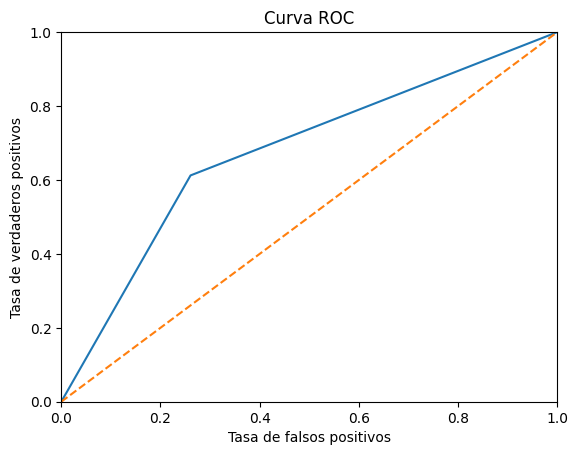

In [30]:
probabilities_valid = model.predict_proba(features_test_ohe)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_test_ohe,predicted_test)

plt.figure()
plt.plot(fpr,tpr)

# Curva ROC para modelo aleatorio
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

Haciendo el modelo con submuestreo se pudo mejorar mucho la calidad del modelo, en comparación a lo que se obtenia cuando no se realizaba nada, debido a que los datos estaban desequilibrados. El valor de F1 subio sugnificativamente para este último modelo comparado al primer modelo de regresión logística que se realizo sin hacerle nada a los datos. Para este caso se obtuvo mejores resultados cuando se hacia submuestreo, es decir que se elimaba una fracción de los datos de la clase predominante para que la cantidad de datos que haya de ambas clases sea muy similar. Para el primer modelo casi la mayoria en donde el modelo predicia negativos no lo eran y no estaba prediciendo casi los 